In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
from tensorflow import keras
import numpy as np
import pandas as pd
import pickle
import os
from datetime import datetime
from sklearn.metrics import confusion_matrix

from measurement_collector import MeasurementCollector
from cache_utils import cache

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
#%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = [15, 15]
    
_db_path = "/home/levcsi/projects/stroke_prediction/data/WUS-v4m.accdb"
_m_path = "/home/levcsi/projects/stroke_prediction/data/biocal.xlsx"
mc = MeasurementCollector('/home/levcsi/projects/stroke_prediction/data', _db_path, _m_path)

2022-05-04 00:37:39.548194: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-04 00:37:39.548225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



##### Load measurements for TRAIN #####
### 202110230 (5, 5) ###
measurement is not found in aux data
measurement_path_dict is OK
### 202110251 (2, 3) ###
measurement_path_dict is OK
### 202110280 (0, 1) ###
measurement_path_dict is OK
### 202111021 (2, 3) ###
measurement_path_dict is OK
### 202111041 (0, 0) ###
measurement_path_dict is OK
### 202111141 (5, 5) ###
measurement_path_dict is OK
### 202111181 (0, 0) ###
measurement_path_dict is OK
### 202112020 (5, 5) ###
measurement_path_dict is OK
### 202112131 (2, 4) ###
measurement_path_dict is OK
### 202112171 (2, 4) ###
measurement_path_dict is OK
### 202201061 (0, 0) ###
measurement_path_dict is OK
### 202201191 (4, 4) ###
measurement_path_dict is OK
### 202201310 (5, 5) ###
missing keys: ALL
measurement is not valid (deleted)
### 202203021 (0, 3) ###
missing keys: ALL
measurement is not valid (deleted)
### 202203221 (1, 2) ###
missing keys: ALL
measurement is not valid (deleted)
### 202203230 (1, 1) ###
measurement_path_dict is OK

In [2]:
@cache
def generate_infer_data(length, step_size, limb, type_of_set, use_cache, key):
    keys_in_order = (("arm", "acc"),
                     ("leg", "acc"),
                     ("arm", "gyr"),
                     ("leg", "gyr"))

    cur_meas_name = None
    result_dict = dict()

    for mean_dict, class_value, meas_name in mc.sweep_mean_with_class_generator(mean_type='all',
                                                                                limb=limb,
                                                                                length=length,
                                                                                step_size=step_size,
                                                                                type_of_set=type_of_set):
        if cur_meas_name != meas_name:
            print(meas_name)
            result_dict[meas_name] = {
                "X": list(),
                "y": list()
            }
            cur_meas_name = meas_name
        
        instance = list()
        for key in keys_in_order:
            if limb != "all" and key[0] != limb:
                continue
            instance.append(mean_dict[key])
        instance = sum(instance, [])

        result_dict[meas_name]["X"].append(instance)
        result_dict[meas_name]["y"].append(class_value)
    
    return result_dict

In [3]:
@cache
def make_prediction(_model, _data_dict, use_cache, key):
    result_dict = dict()
    cur_meas_name = None
    
    for meas_name, x_y_dict in _data_dict.items():
        if cur_meas_name != meas_name:
            print(meas_name)
            result_dict[meas_name] = {
                "class_values": x_y_dict["y"],
                "y_pred_list": list()
            }
            cur_meas_name = meas_name
        
        y_pred_list = model.predict(x_y_dict["X"])
        result_dict[meas_name]["y_pred_list"] = y_pred_list
    
    return result_dict

In [23]:
import matplotlib.dates as md

def make_plot(result_dict, save=True, type_of_set="train"):
    plt.ion()
    
    pred_is_healthy_list = list()
    is_healty_list = list()
    for meas_name, pred_dict in result_dict.items():
        print(meas_name)
        print("class value: {}".format(set(pred_dict["class_values"])))

        pred_array = np.array(pred_dict["y_pred_list"]).argmax(axis=1)
        percentage_list = [len(pred_array[pred_array == value]) / len(pred_array) * 100 for value in range(6)]
        fig, axs = plt.subplots(4, 1, facecolor="w")

        color_list = ['blue', 'blue', 'blue', 'blue', 'blue', 'blue']
        for i in set(pred_dict["class_values"]):
            color_list[i] = "red"
        graph = axs[0].bar(list(range(6)),
                           percentage_list,
                           color=color_list)

        for p in graph:
            height = p.get_height()
            axs[0].text(x=p.get_x() + p.get_width() / 2, y=height+1,
            s="{:.3} %".format(height),
            ha='center')

        axs[0].set_ylim(-5, 105)
        axs[0].legend(["Ratio of detections during the measurment"], loc='best')
        axs[0].grid(True)
        
        pred_is_healthy = np.array(pred_dict["y_pred_list"]).argmax(axis=1) > 4.5
        is_healty = np.array(pred_dict["class_values"]) > 4.5
        ratio = np.sum(pred_is_healthy == is_healty) / len(pred_is_healthy)
        
        pred_is_healthy_list.append(pred_is_healthy)
        is_healty_list.append(np.ones_like(pred_is_healthy) * is_healty)
        
        axs[1].pie([ratio, 1 - ratio], explode=(0, 0.1), labels=["True", "False"], autopct='%1.1f%%',
        shadow=True, startangle=90)
        axs[1].legend(["Prediction in terms of is it healty or not"], loc='best')

        
        xformatter = md.DateFormatter('%H:%M')
        xlocator = md.MinuteLocator(interval=2)
        
        axs[2].plot(np.array(pred_dict["y_pred_list"]).argmax(axis=1), label=meas_name)
        axs[2].plot(pred_dict["class_values"], label="class_values ({})".format(set(pred_dict["class_values"])))
        axs[2].axis([None, None, -0.5, 5.5])
        axs[2].legend(loc='best')
        axs[2].grid()
        
        axs[2].xaxis.set_major_formatter(xformatter)
        axs[2].xaxis.set_major_locator(xlocator)
        
        axs[3].plot(np.array(pred_dict["y_pred_list"]).max(axis=1) * 100, label="confidence of prediction")
        axs[3].plot([a[i] * 100 for a, i in zip(pred_dict["y_pred_list"], pred_dict["class_values"])], label="confidence of prediction for true label")
        axs[3].axis([None, None, -5, 105])
        axs[3].legend(loc='best')
        axs[3].grid()
        
        if save:
            os.makedirs("./plots/plots_{}m_{}step_{}/{}/".format( int(length / (60 * 25)), step_size, datetime.now().strftime('%Y-%m-%d-%H'), type_of_set), exist_ok=True)
            plt.savefig("./plots/plots_{}m_{}step_{}/{}/{}.png".format(int(length / (60 * 25)), step_size, datetime.now().strftime('%Y-%m-%d-%H'), type_of_set, meas_name))
            
        plt.show()
        
    
    cm = confusion_matrix(~np.concatenate(is_healty_list), ~np.concatenate(pred_is_healthy_list))
        
    #if ratio == 1 and is_healty:
    #    cm = np.array([[0, 0],
    #                   [0, 1]])
    #elif ratio == 1 and not is_healty:
    #    cm = np.array([[1, 0],
    #                   [0, 0]])

    print(cm)
    sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
    print(sensitivity)
    specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    print(specificity)
    
    color_list = ['blue', 'red']
    
    fig = plt.figure(facecolor="w")
    ax = fig.add_axes([0,0,1,1])
    langs = ['sensitivity', 'specificity']
    students = [sensitivity * 100, specificity * 100]
    graph = ax.bar(langs, students, color=color_list)
    
    for p in graph:
        height = p.get_height()
        print(type(height))
        ax.text(x=p.get_x() + p.get_width() / 2, y=height+1,
        s="{:.2f} %".format(height),
        ha='center')
    
    ax.legend(["sensitivity - specificity"], loc='best')
    ax.grid(True)
    
    if save:
        os.makedirs("./plots/plots_{}m_{}step_{}/{}/".format(minutes, step_size, datetime.now().strftime('%Y-%m-%d-%H'), type_of_set), exist_ok=True)
        plt.savefig("./plots/plots_{}m_{}step_{}/{}/sens_spec.png".format(minutes, step_size, datetime.now().strftime('%Y-%m-%d-%H'), type_of_set))
            
    plt.show()


In [5]:
minutes = 90
length = 25 * 60 * minutes
step_size = 500
limb = "all"
sample_size = 1000000
save_plot = False

In [7]:
model = keras.models.load_model('./models/model_{}_{}_{}'.format(minutes, sample_size, limb))
model.summary()

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12)]              0         
                                                                 
 hiddel_layer (Dense)        (None, 512)               6656      
                                                                 
 hiddel_layer_2 (Dense)      (None, 256)               131328    
                                                                 
 hiddel_layer_3 (Dense)      (None, 128)               32896     
                                                                 
 prediction (Dense)          (None, 6)                 774       
                                                                 
Total params: 171,654
Trainable params: 171,654
Non-trainable params: 0
_________________________________________________________________


In [27]:
type_of_set = "train"
key = "{}".format([length, step_size, limb, type_of_set, len(mc.measurement_dict[type_of_set])])

train_infer_data = generate_infer_data(length, step_size, limb, type_of_set, use_cache=True, key=key)

Use cache with path: cache/[135000, 500, 'all', 'train', 13]_generate_infer_data.pkl



In [30]:
type_of_set = "train"
key = "{}".format([length, step_size, limb, type_of_set, len(mc.measurement_dict[type_of_set])])

train_prediction_dict = make_prediction(model, train_infer_data, use_cache=True, key=key)

Use cache with path: cache/[135000, 500, 'all', 'train', 13]_make_prediction.pkl



202110230
class value: 5


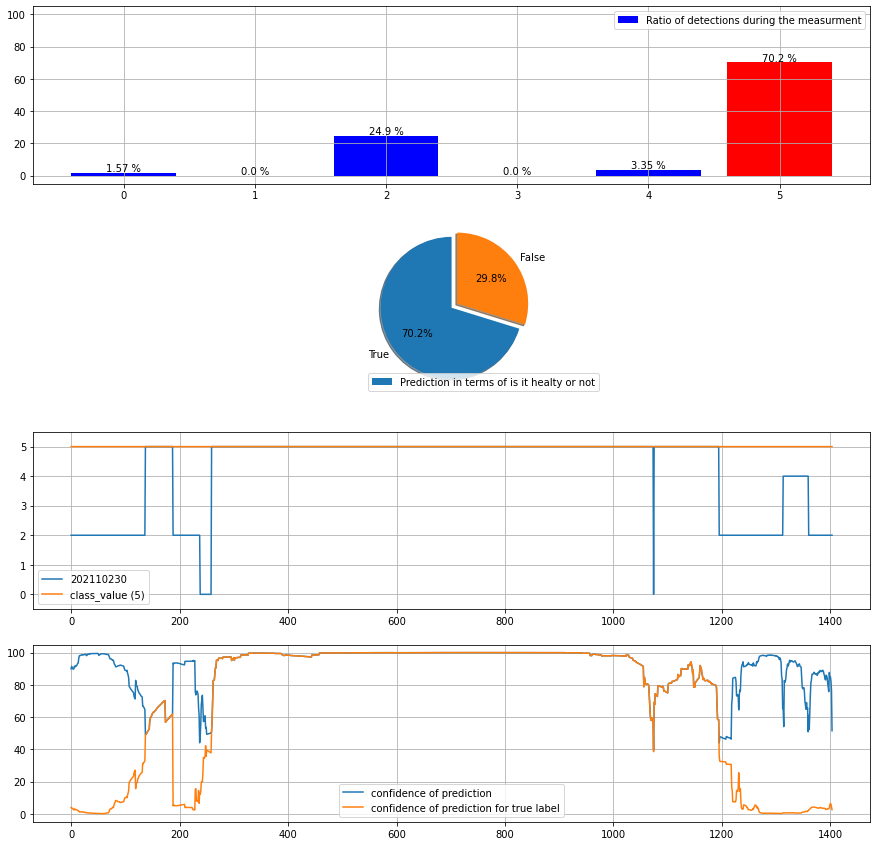

202110251
class value: 2


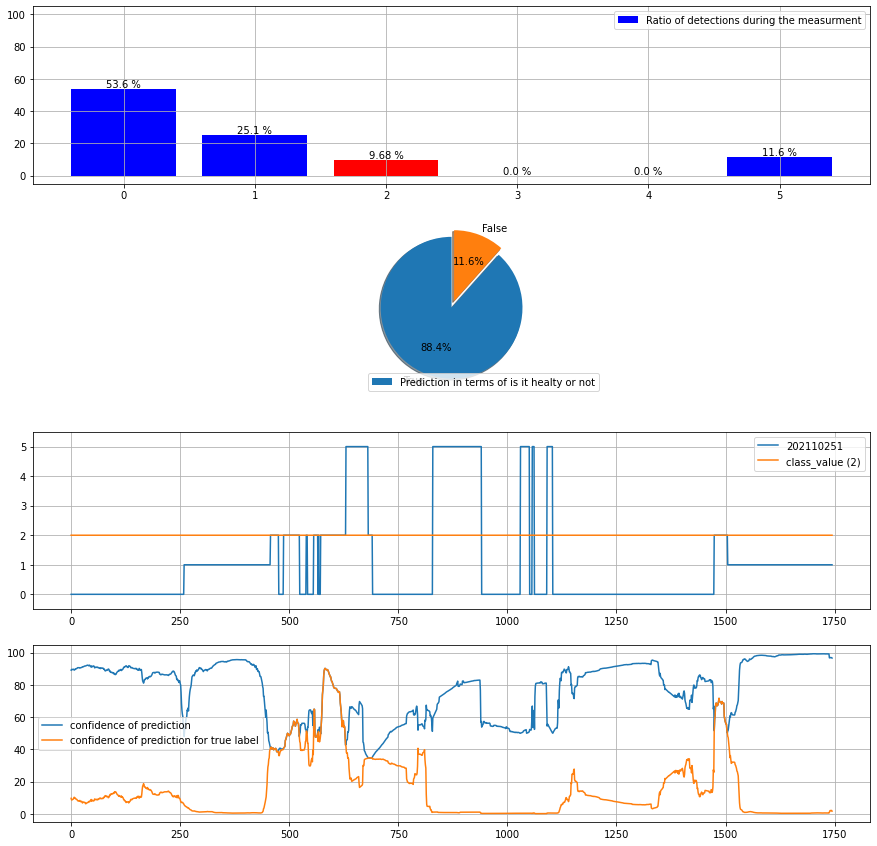

202110280
class value: 0


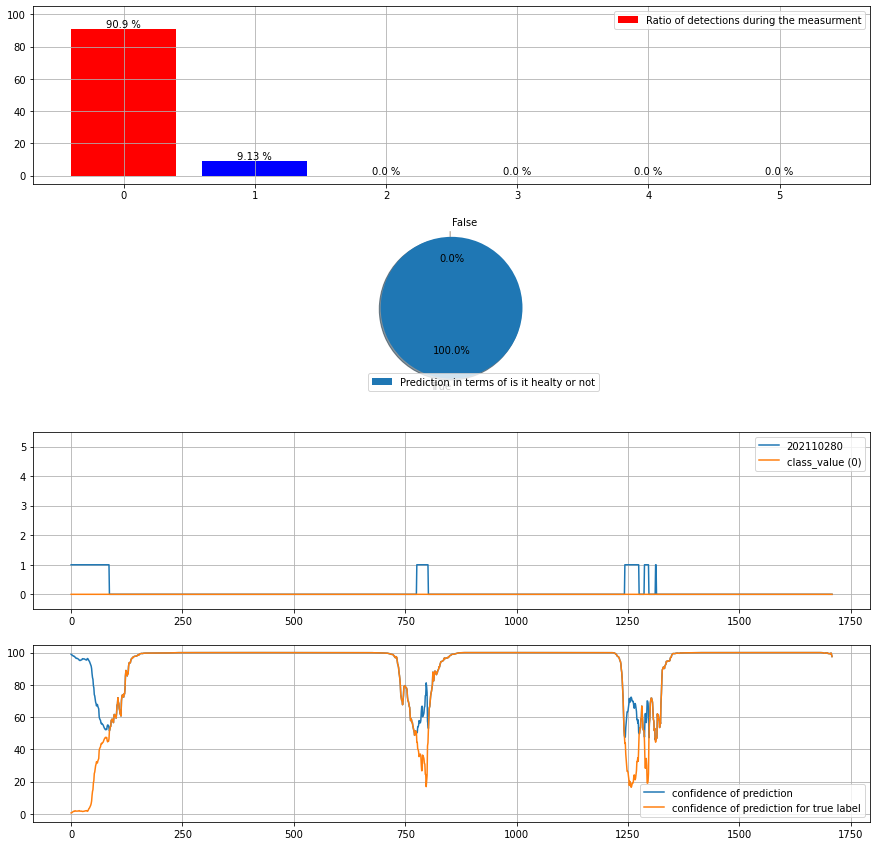

202111021
class value: 2


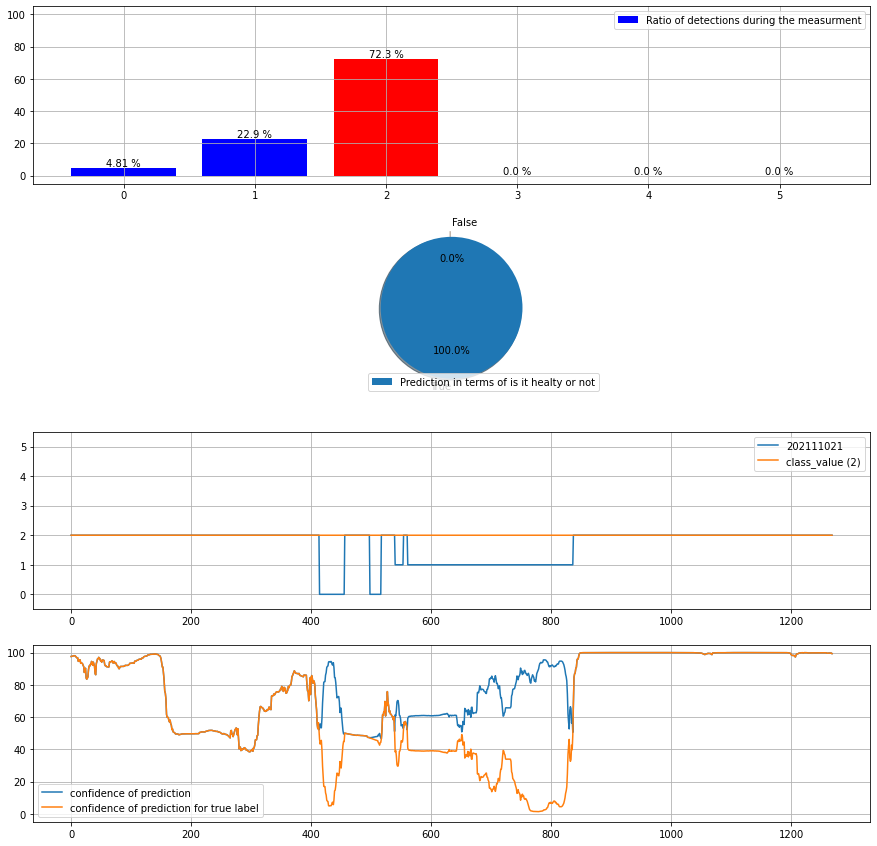

202111041
class value: 0


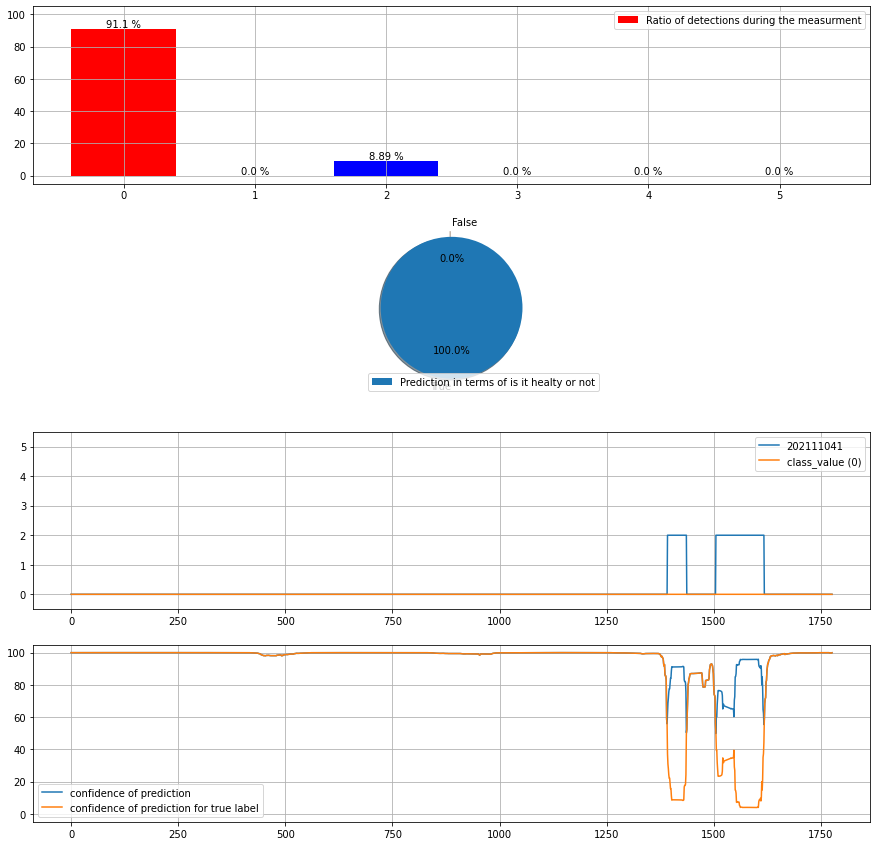

202111141
class value: 5


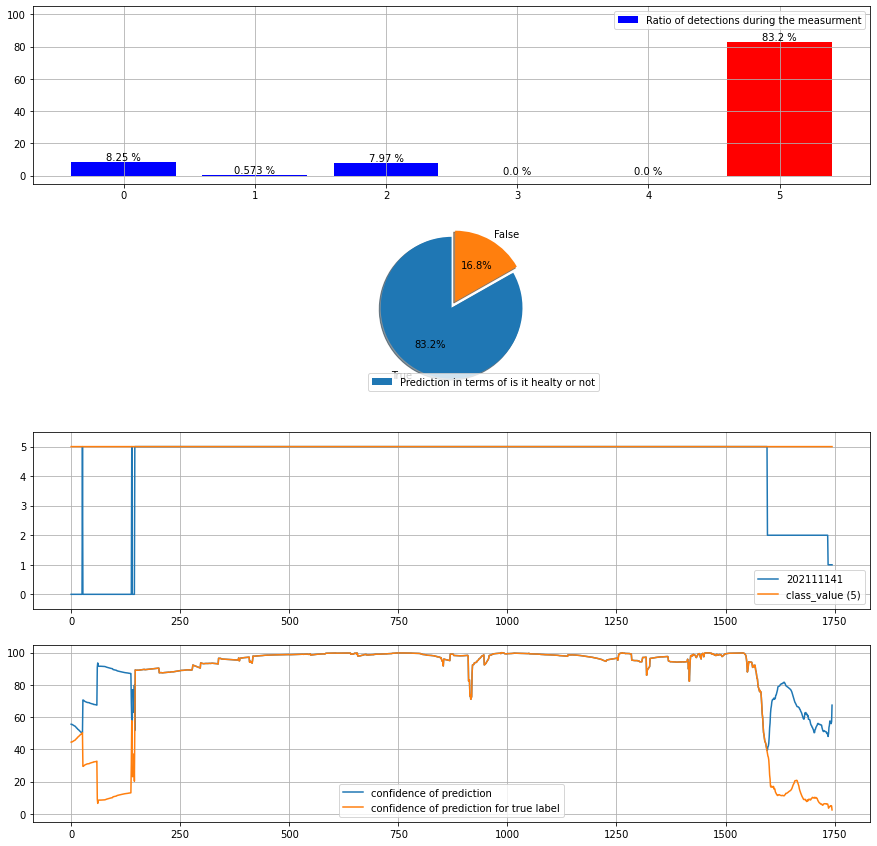

202111181
class value: 0


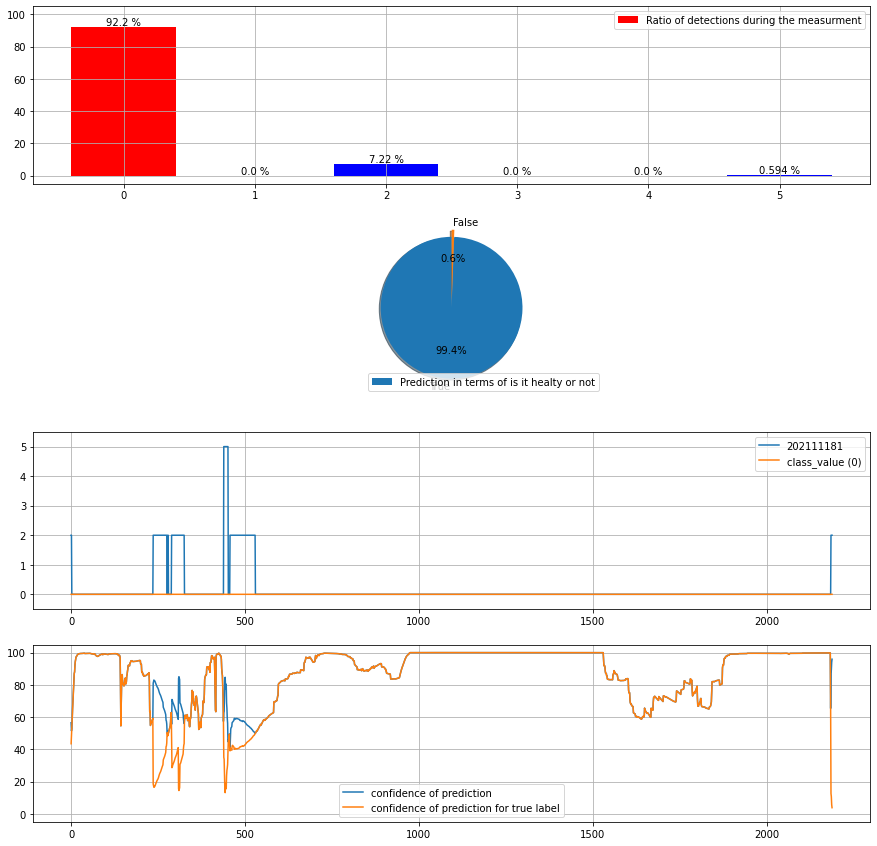

202112020
class value: 5


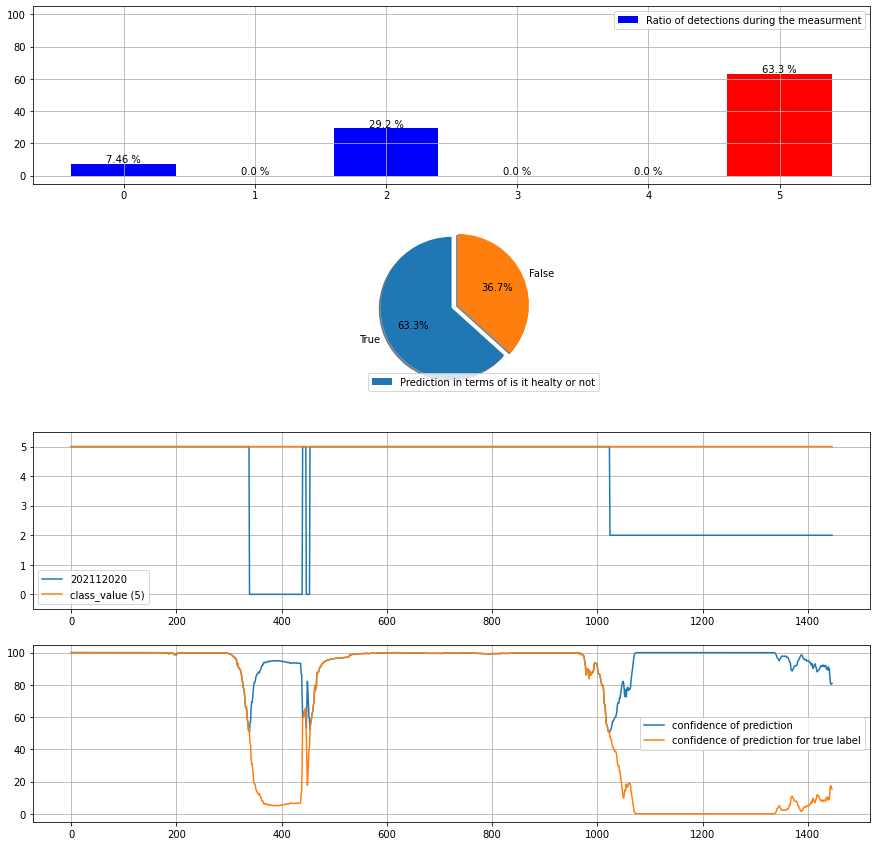

202112131
class value: 2


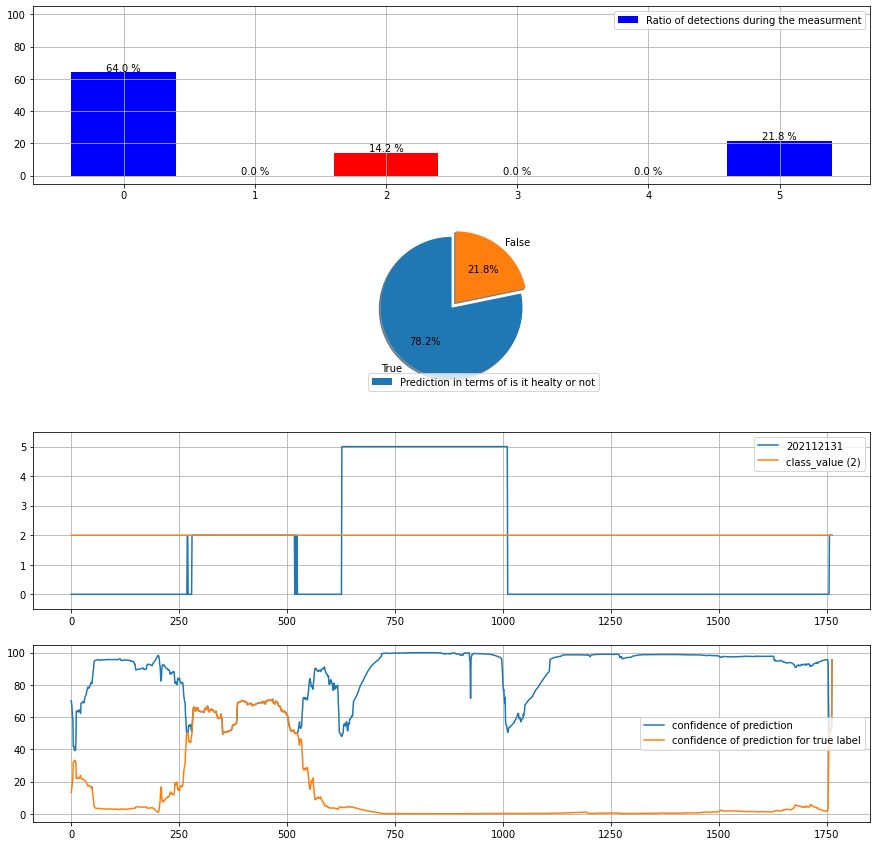

202112171
class value: 2


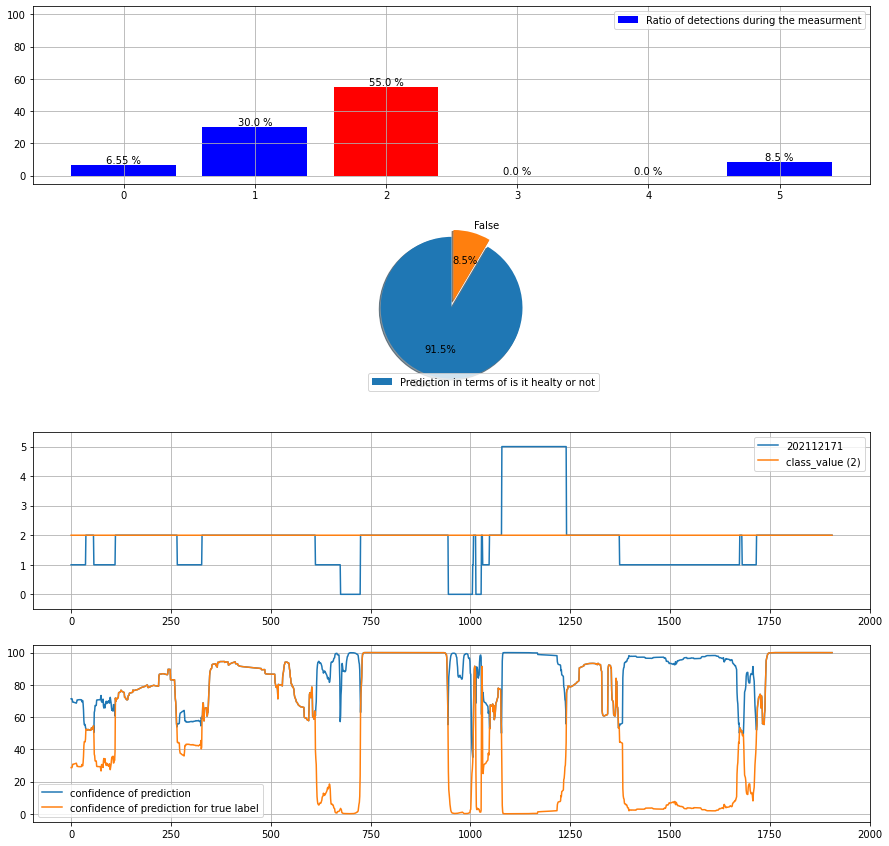

202201061
class value: 0


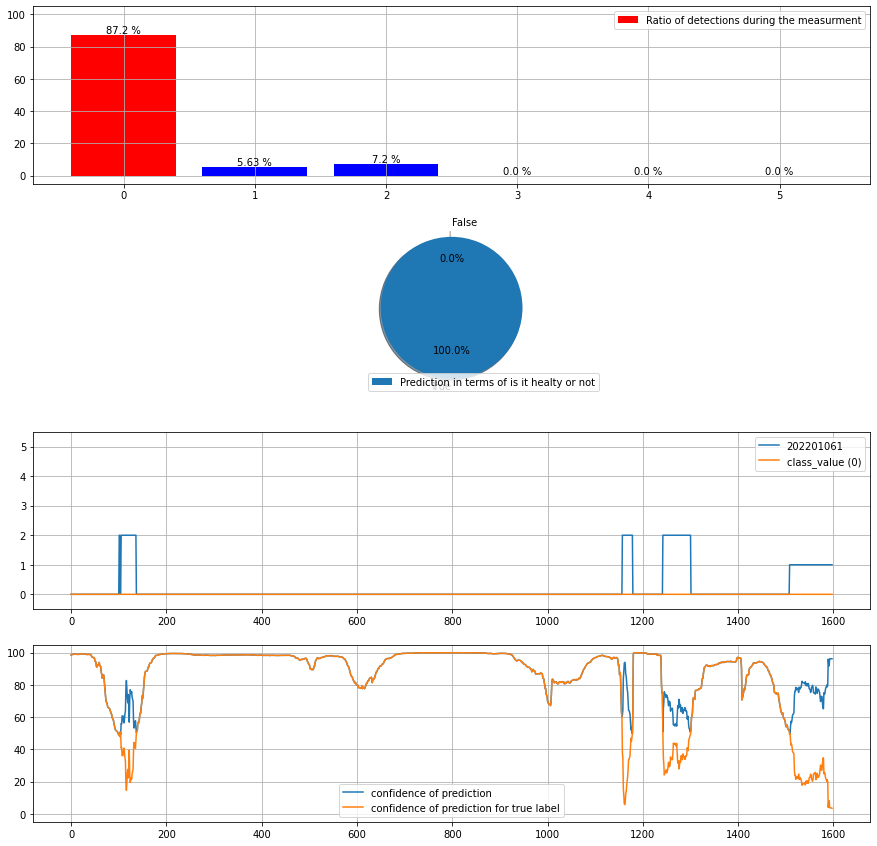

202201191
class value: 4


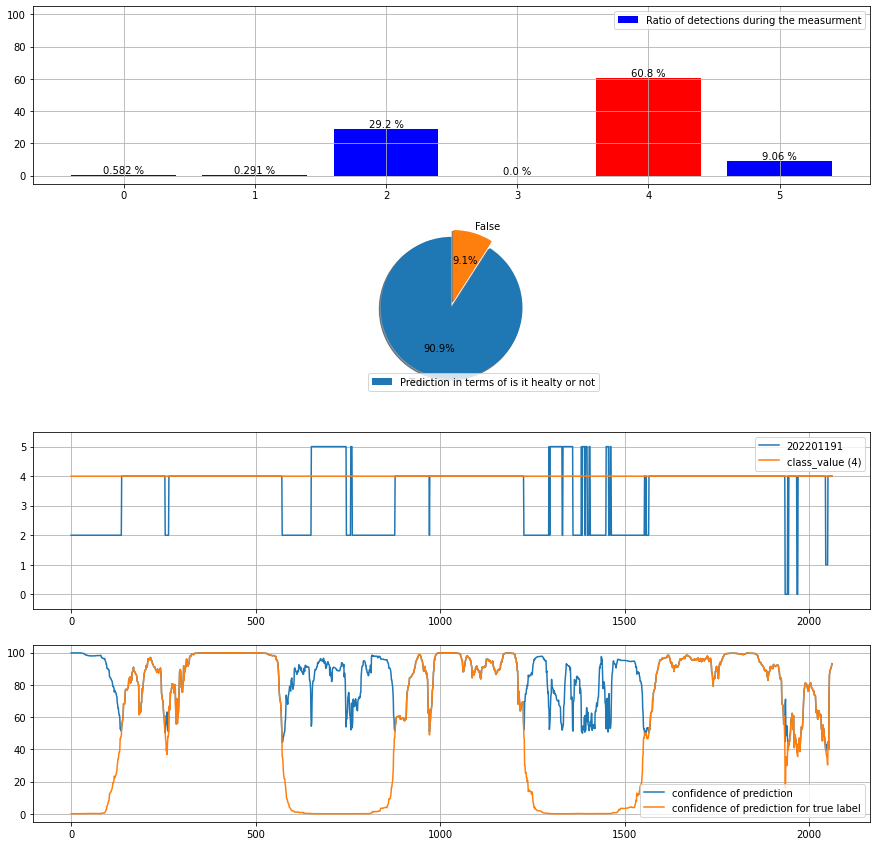

202203230
class value: 1


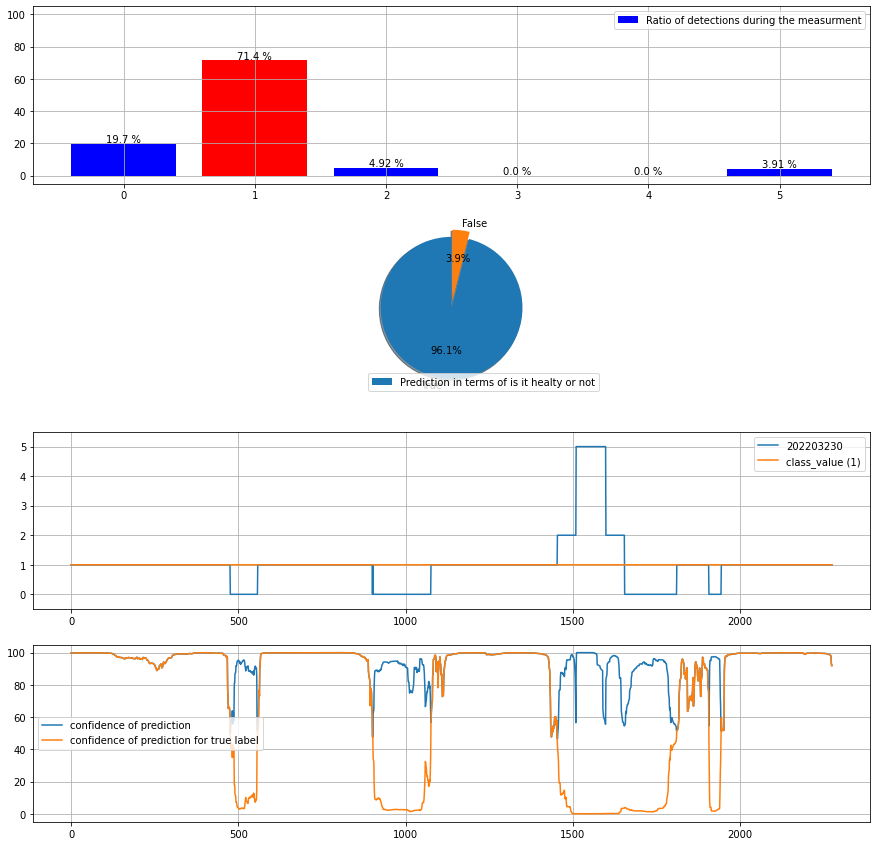

[[ 3354  1242]
 [ 1037 17259]]
0.7297650130548303
0.9433209444687364
<class 'numpy.float64'>
<class 'numpy.float64'>


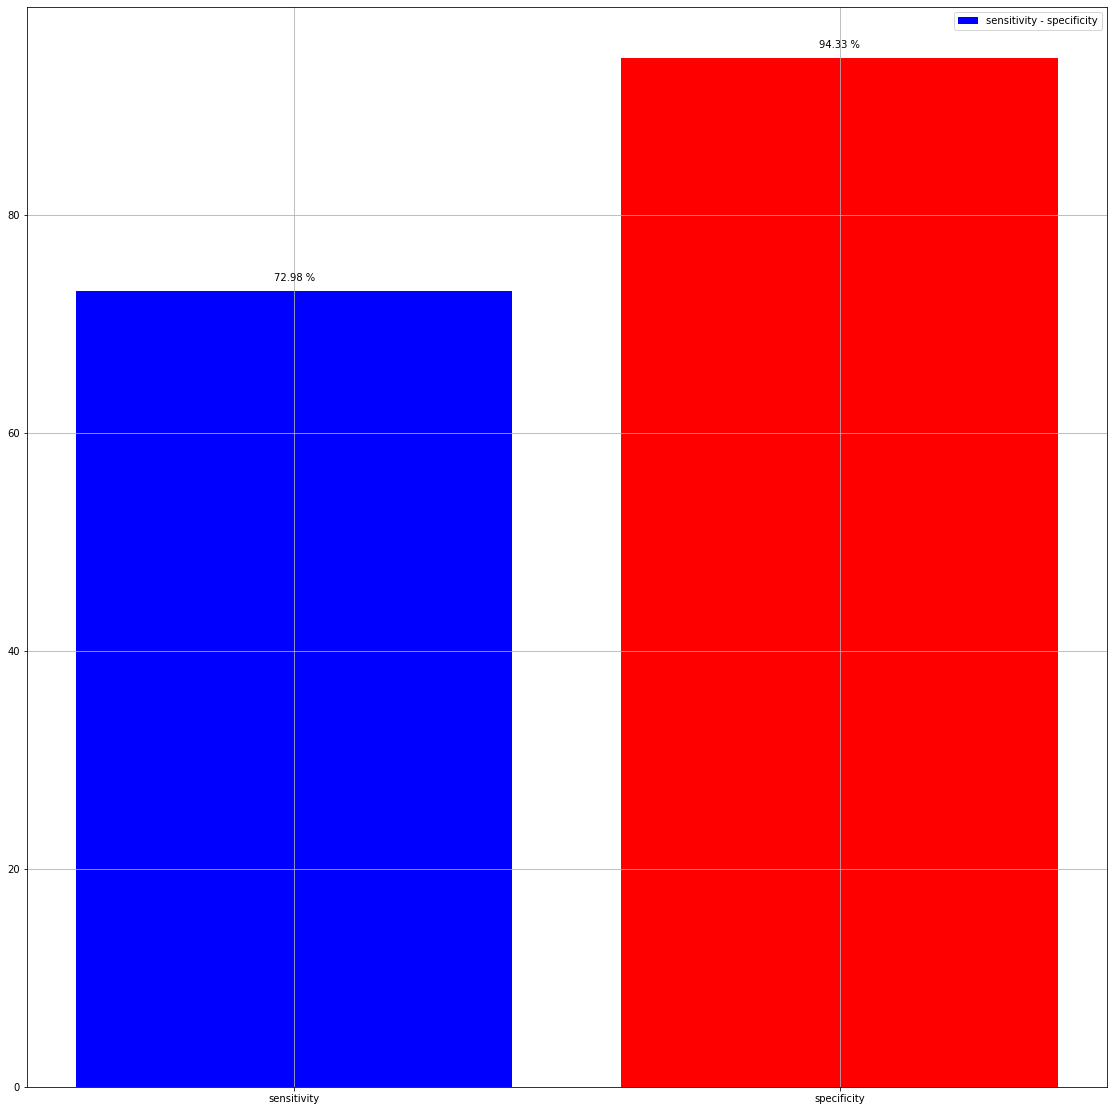

In [31]:
type_of_set = "train"
make_plot(train_prediction_dict, save=save_plot, type_of_set=type_of_set)

In [32]:
type_of_set = "test"
key = "{}".format([length, step_size, limb, type_of_set, len(mc.measurement_dict[type_of_set])])

test_infer_data = generate_infer_data(length, step_size, limb, type_of_set, use_cache=True, key=key)

Use cache with path: cache/[135000, 500, 'all', 'test', 2]_generate_infer_data.pkl



In [33]:
type_of_set = "test"
key = "{}".format([length, step_size, limb, type_of_set, len(mc.measurement_dict[type_of_set])])

test_prediction_dict = make_prediction(model, test_infer_data, use_cache=True, key=key)

Use cache with path: cache/[135000, 500, 'all', 'test', 2]_make_prediction.pkl



202203021
class value: 0


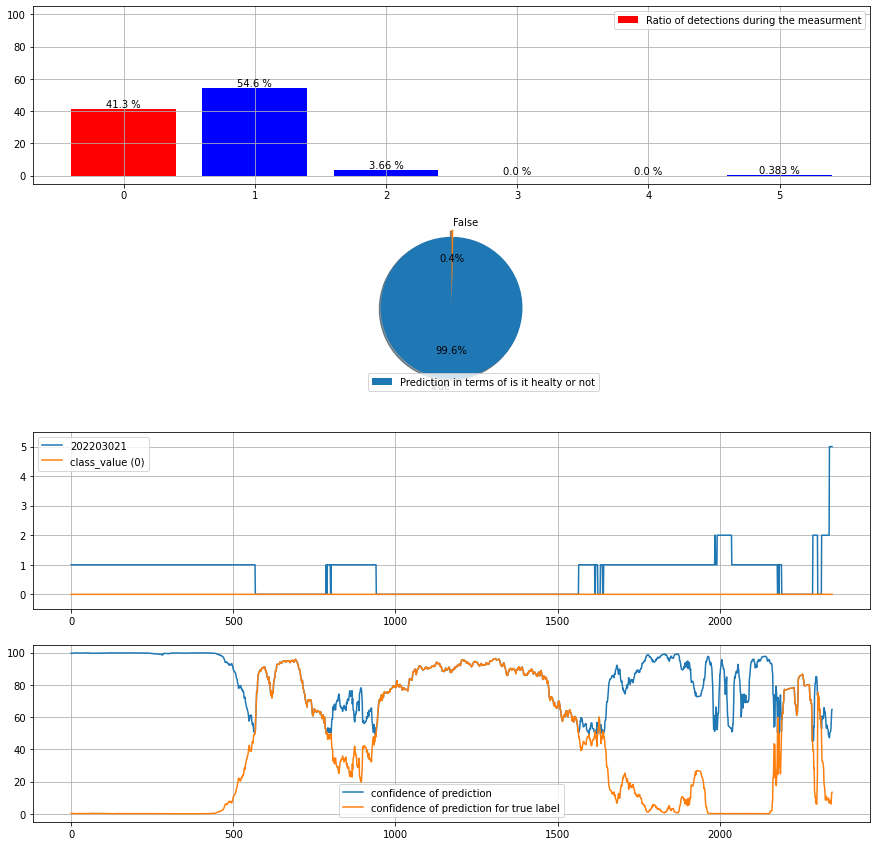

202203221
class value: 1


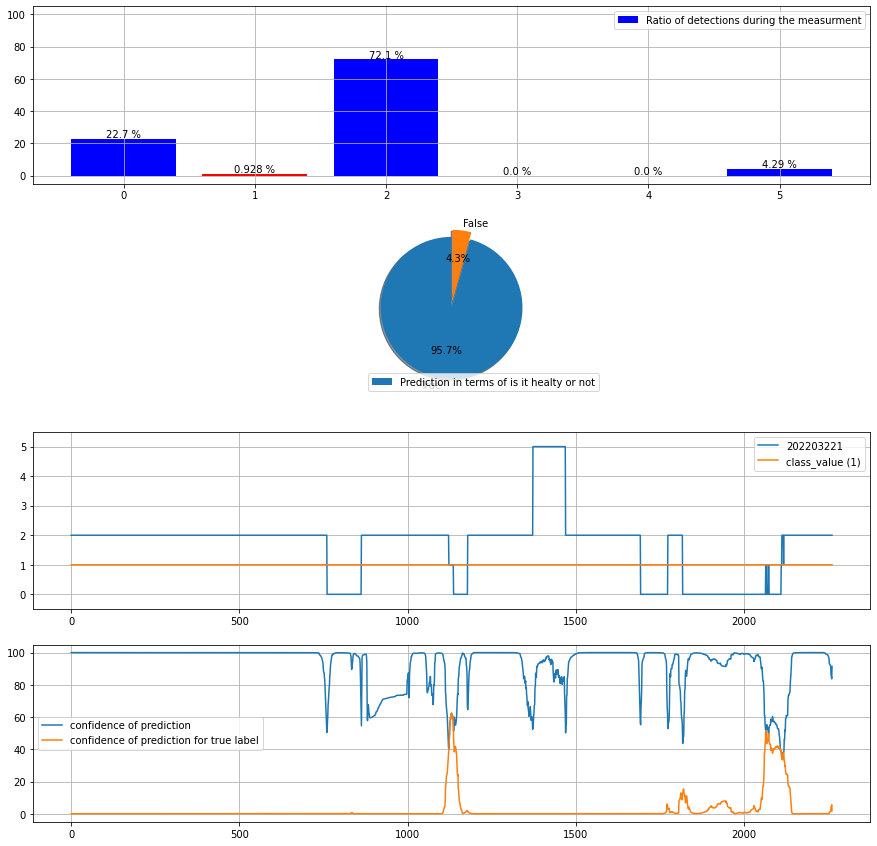

/tmp/ipykernel_21720/605504023.py:72: RuntimeWarning: invalid value encountered in long_scalars
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
posx and posy should be finite values
posx and posy should be finite values


[[   0    0]
 [ 106 4504]]
nan
0.9770065075921909
<class 'numpy.float64'>
<class 'numpy.float64'>


posx and posy should be finite values
posx and posy should be finite values


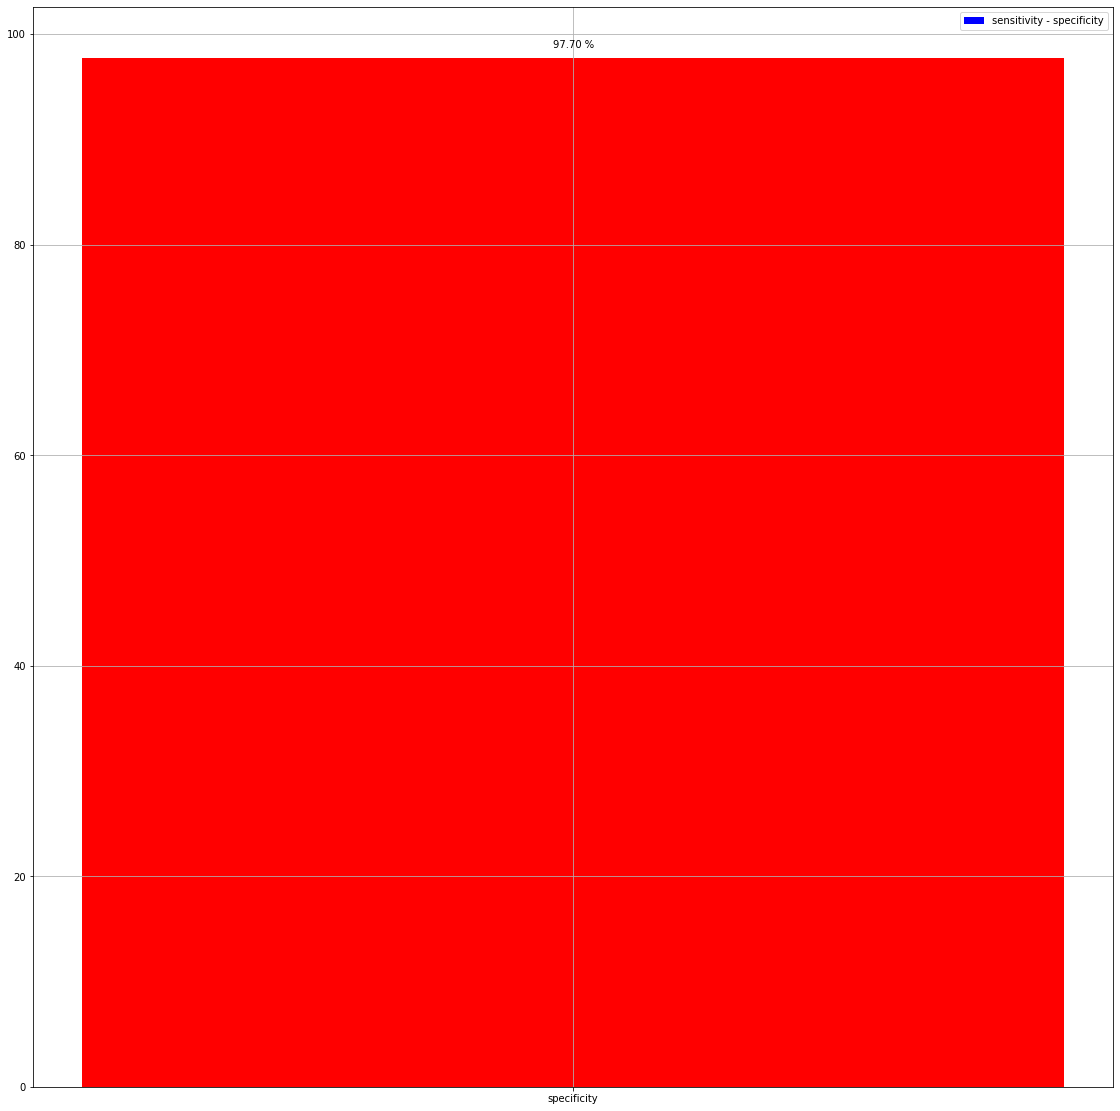

In [34]:
type_of_set = "test"
make_plot(test_prediction_dict, save=save_plot, type_of_set=type_of_set)

In [9]:
type_of_set = "mixed"
key = "{}".format([length, step_size, limb, type_of_set, len(mc.measurement_dict[type_of_set])])

mixed_infer_data = generate_infer_data(length, step_size, limb, type_of_set, use_cache=True, key=key)

Use cache with path: cache/[135000, 500, 'all', 'mixed', 1]_generate_infer_data.pkl

[Errno 2] No such file or directory: "cache/[135000, 500, 'all', 'mixed', 1]_generate_infer_data.pkl"
Cache loading is unsuccessful!

mixed_1
Cache saving is successful with path: cache/[135000, 500, 'all', 'mixed', 1]_generate_infer_data.pkl



In [10]:
type_of_set = "mixed"
key = "{}".format([length, step_size, limb, type_of_set, len(mc.measurement_dict[type_of_set])])

mixed_prediction_dict = make_prediction(model, mixed_infer_data, use_cache=True, key=key)

Use cache with path: cache/[135000, 500, 'all', 'mixed', 1]_make_prediction.pkl

[Errno 2] No such file or directory: "cache/[135000, 500, 'all', 'mixed', 1]_make_prediction.pkl"
Cache loading is unsuccessful!

mixed_1
Cache saving is successful with path: cache/[135000, 500, 'all', 'mixed', 1]_make_prediction.pkl



In [ ]:
type_of_set = "mixed"
make_plot(mixed_prediction_dict, save=save_plot, type_of_set=type_of_set)

mixed_1
class value: {2, 5}


Locator attempting to generate 1327393 ticks ([-83.8, ..., 1759.8]), which exceeds Locator.MAXTICKS (1000).


## Save results

In [4]:
pickle.dump(result_dict, open("./result_dict_{}_{}.pkl".format(length, step_size), "wb"))

## Load results

In [3]:
result_dict = pickle.load(open("./result_dict_90000_500.pkl", "rb"))

202110230
class value: 5


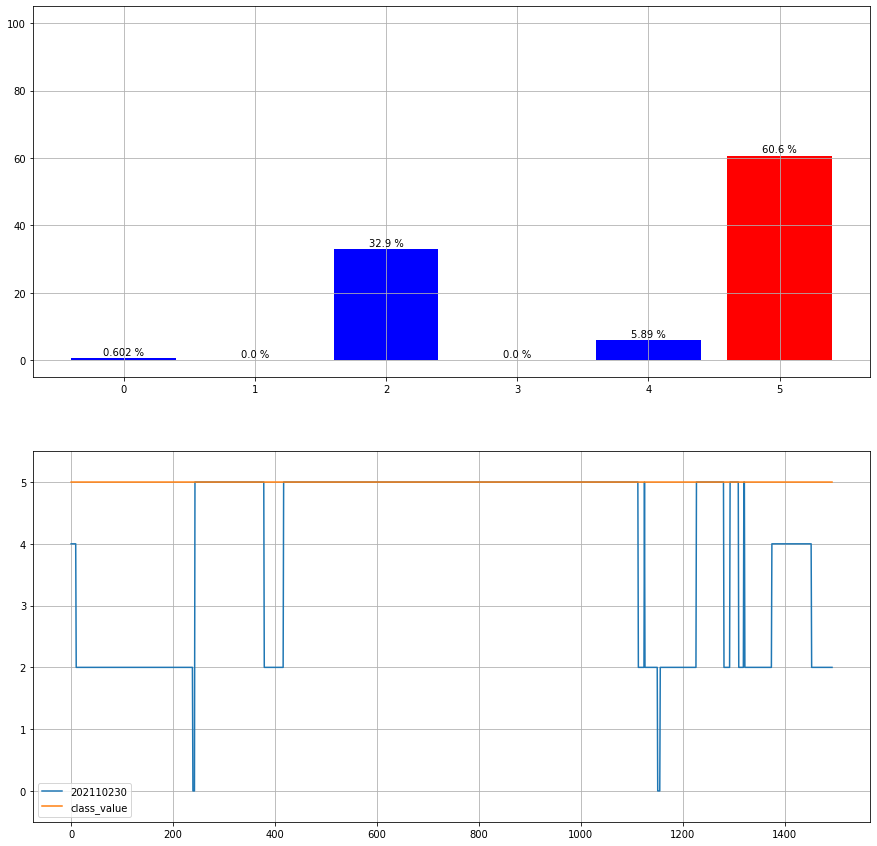

202110251
class value: 2


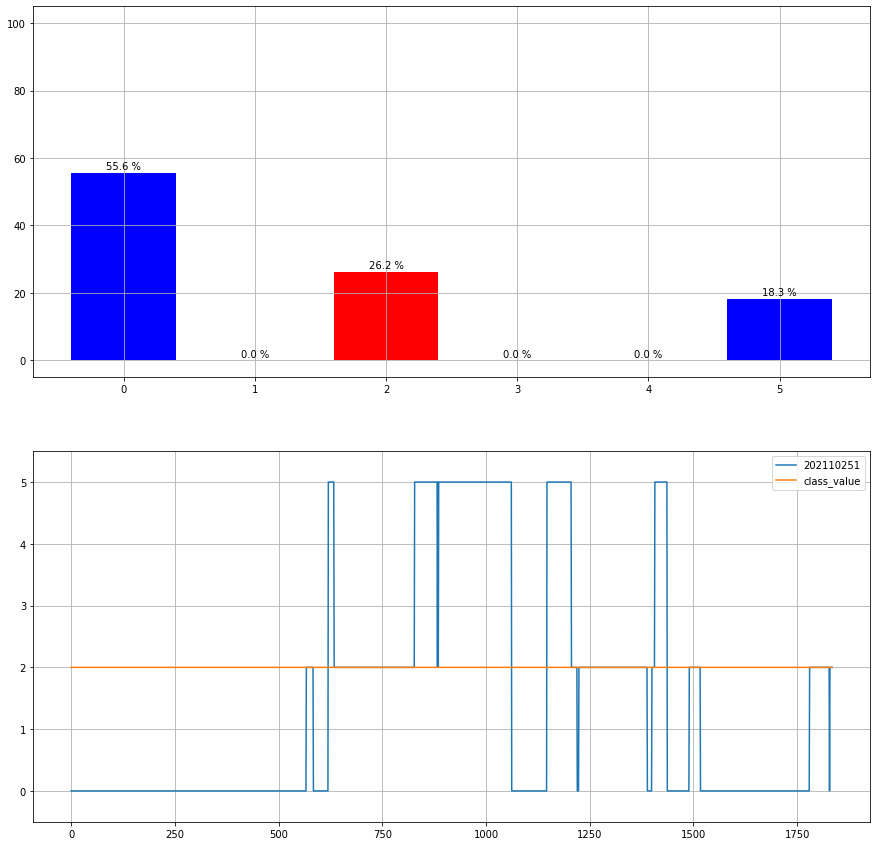

202110280
class value: 0


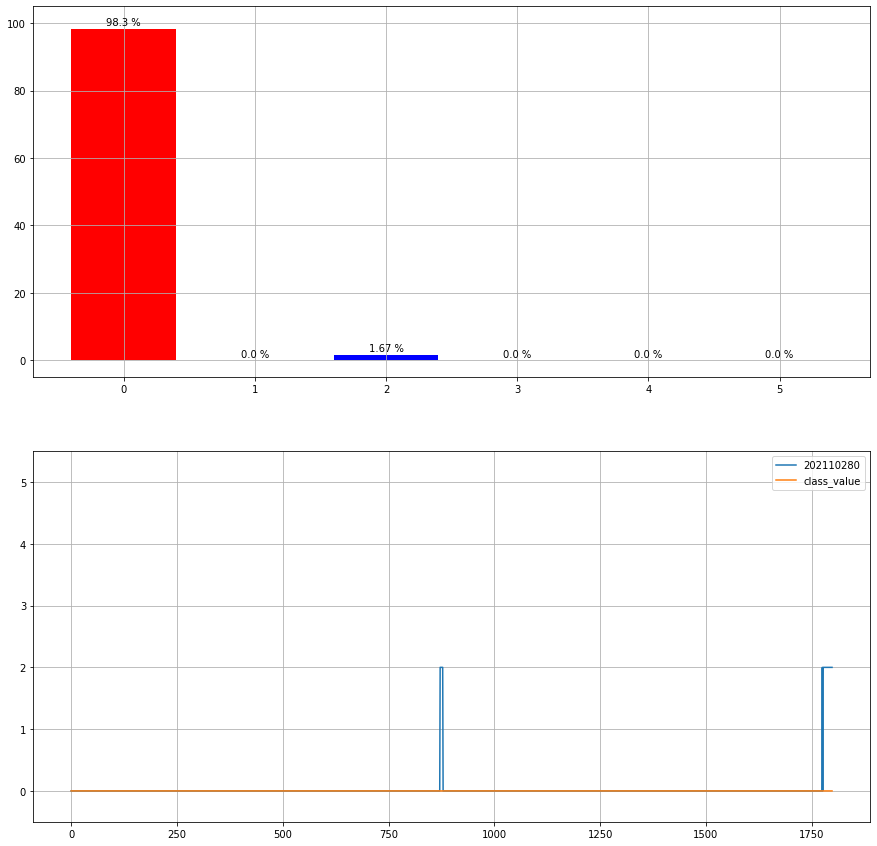

202111021
class value: 2


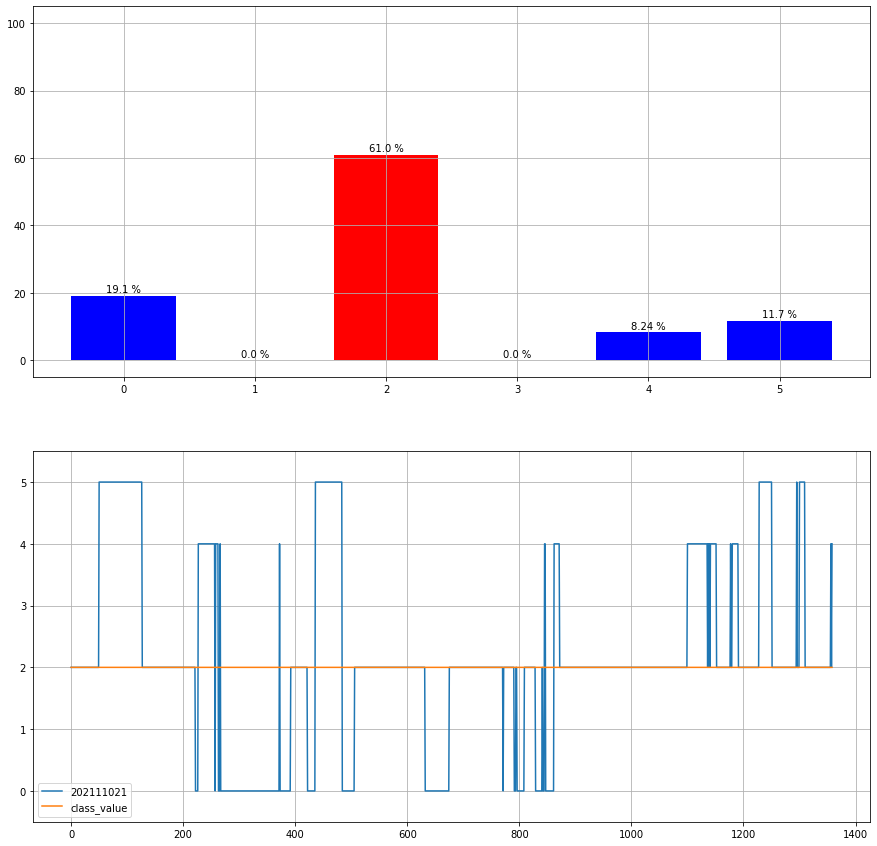

202111041
class value: 0


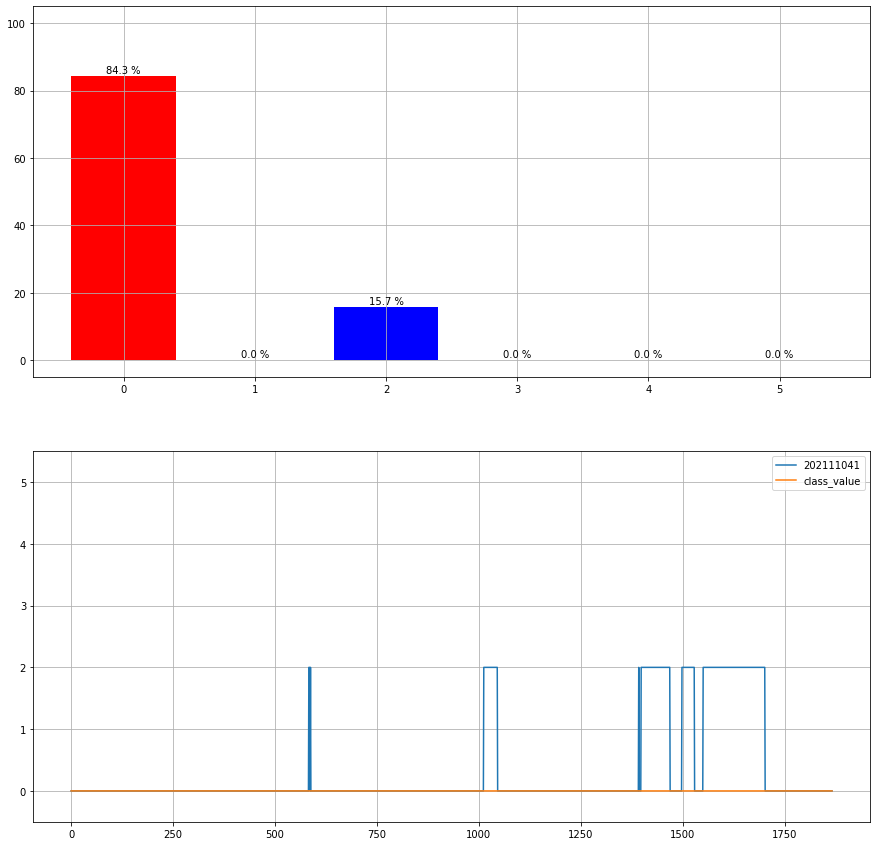

202111141
class value: 5


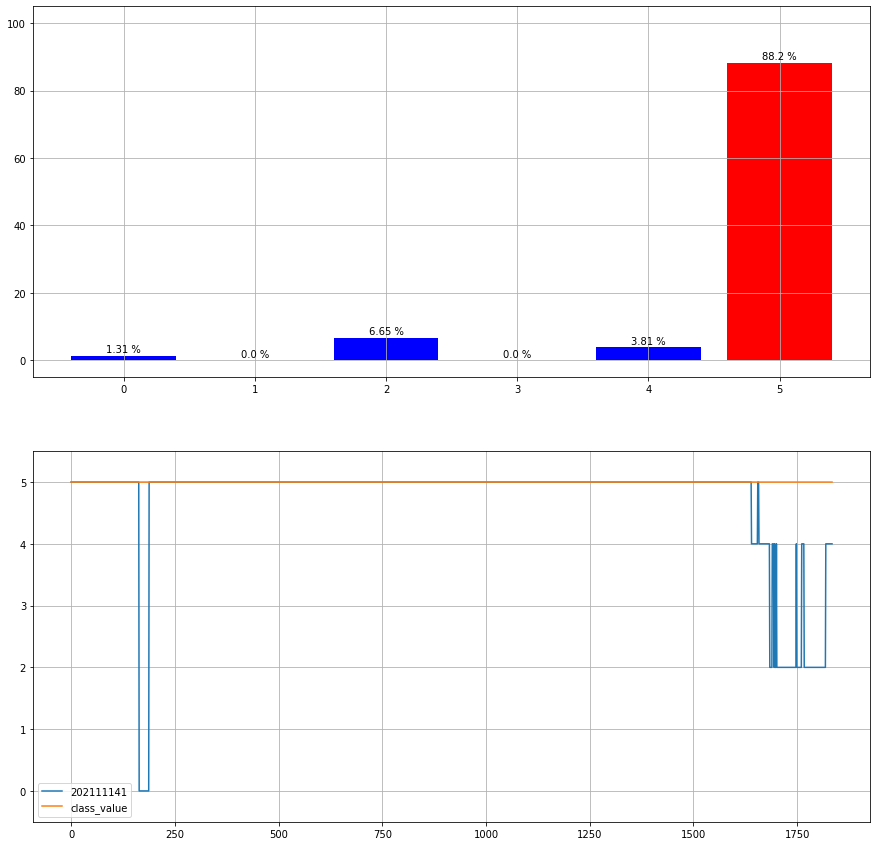

202111181
class value: 0


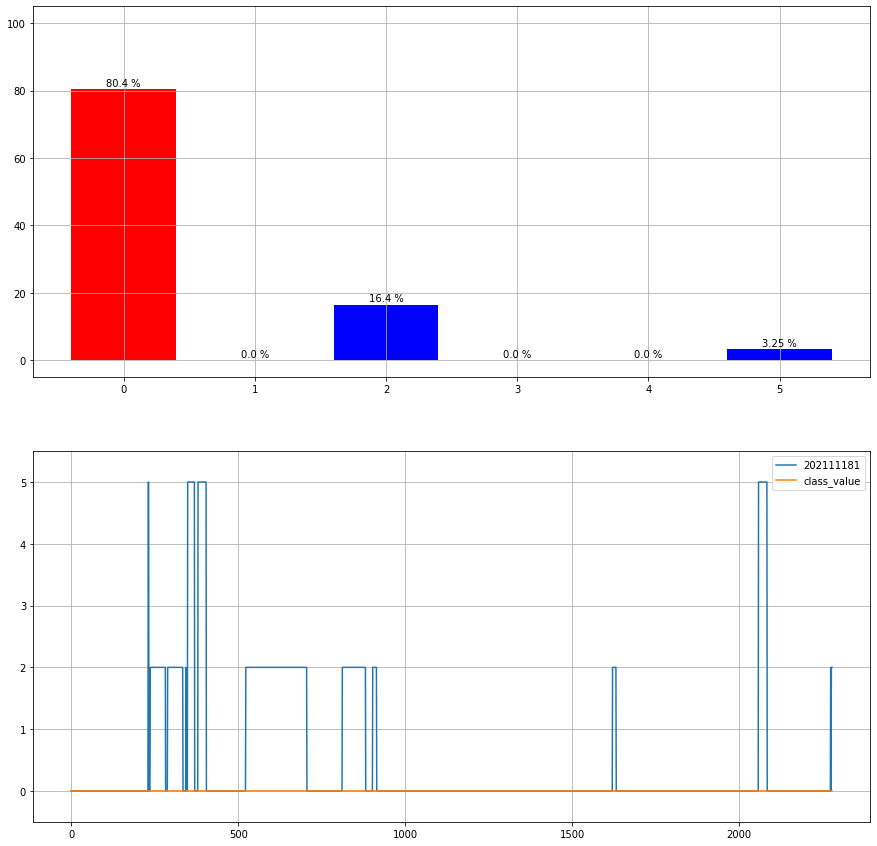

202112020
class value: 5


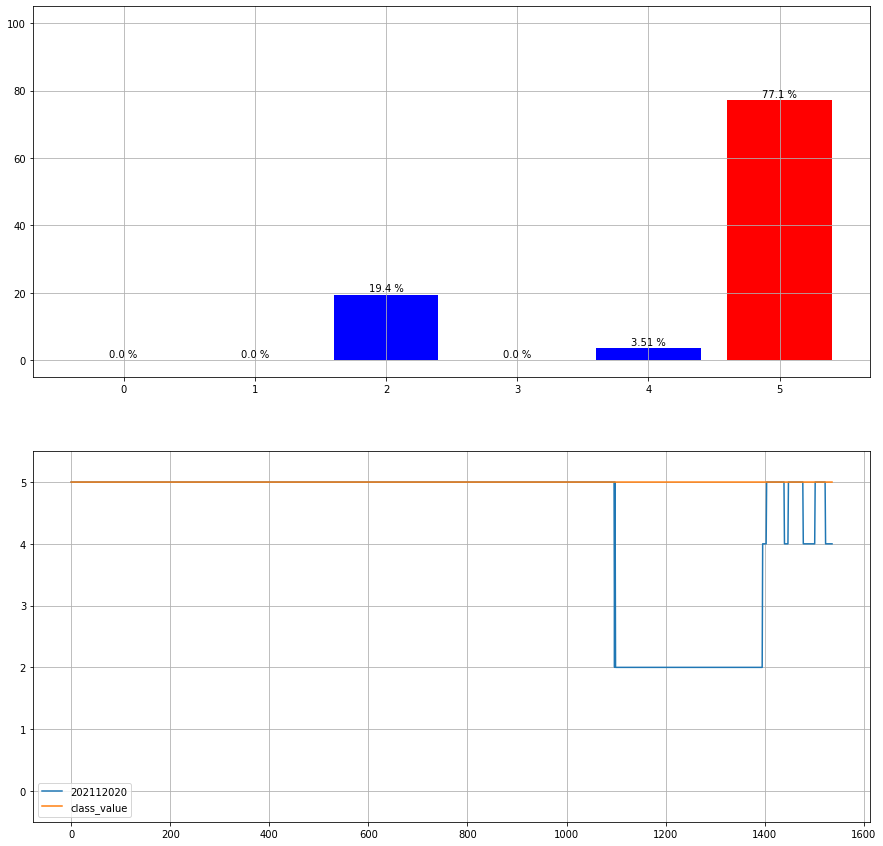

202112131
class value: 2


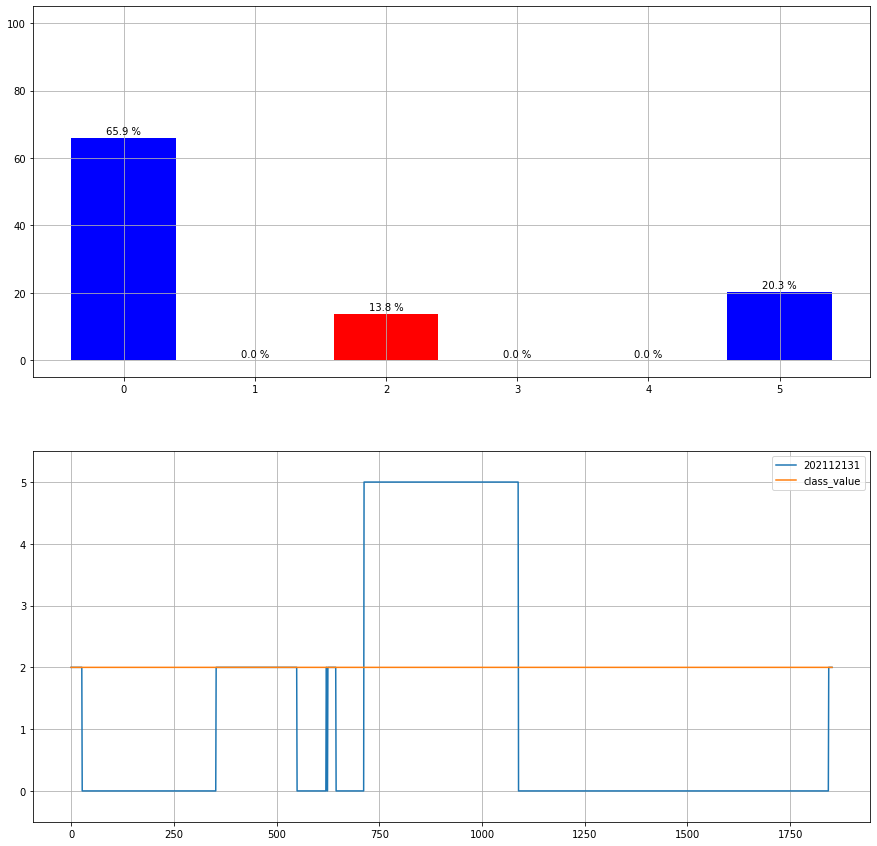

202112171
class value: 2


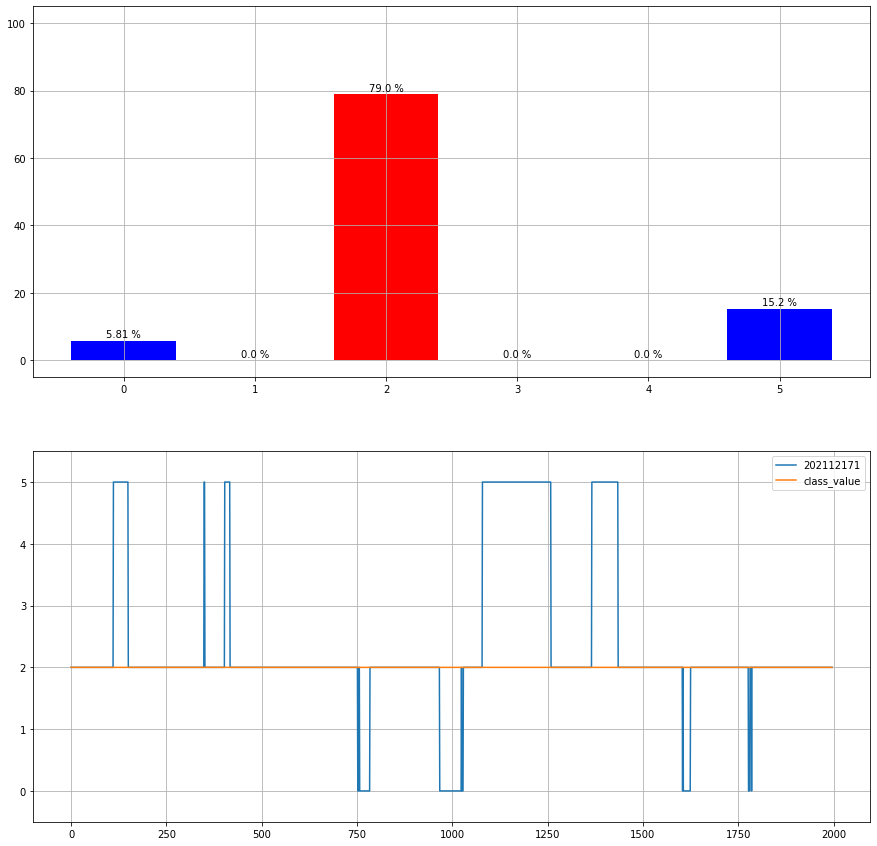

202201061
class value: 0


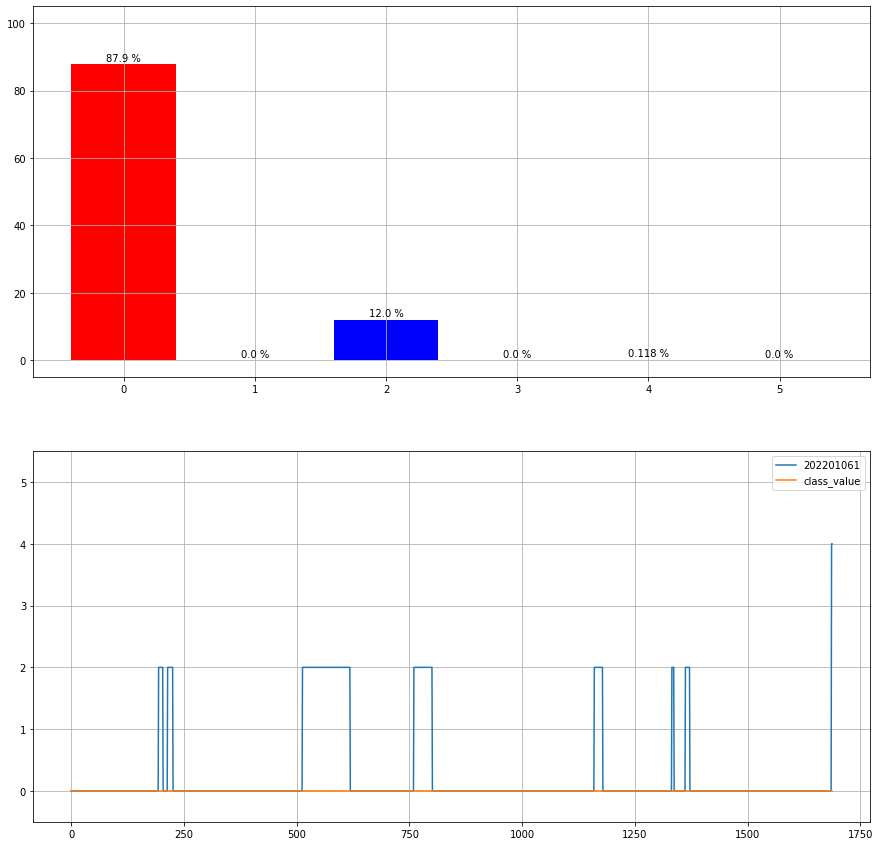

202201191
class value: 4


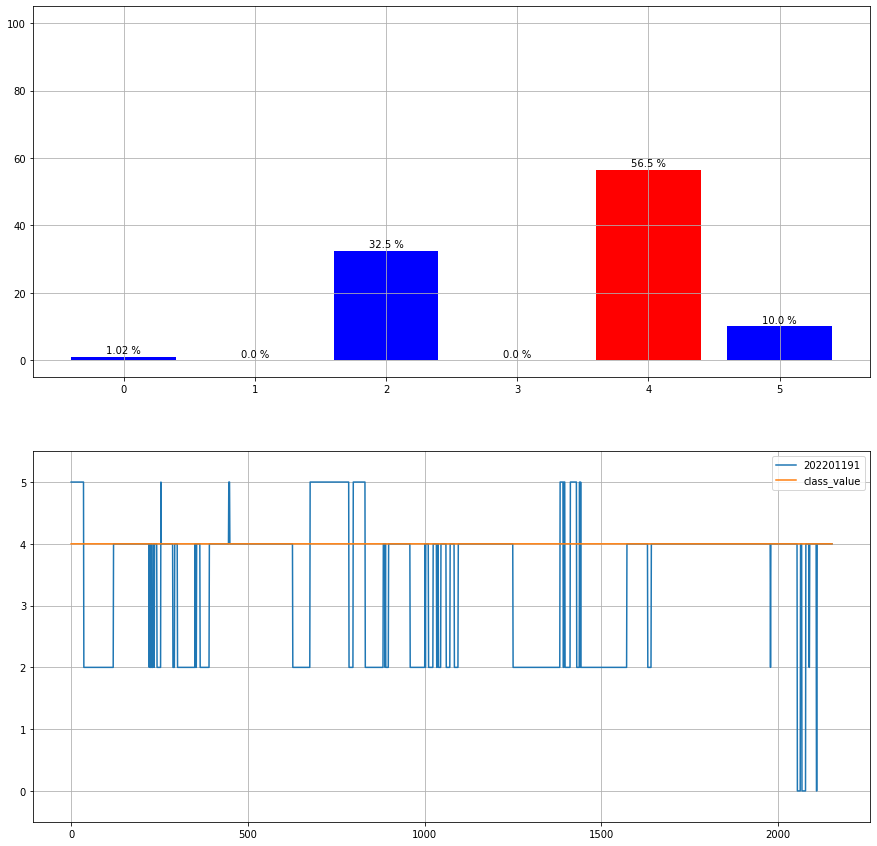

In [11]:
plt.ion()
for meas_name, pred_dict in result_dict.items():
    print(meas_name)
    print("class value: {}".format(pred_dict["class_value"]))
    
    pred_array = np.array(pred_dict["y_pred_list"]).argmax(axis=1)
    percentage_list = [len(pred_array[pred_array == value]) / len(pred_array) * 100 for value in range(6)]
    fig, axs = plt.subplots(2, 1)
    
    color_list = ['blue', 'blue', 'blue', 'blue', 'blue', 'blue']
    color_list[pred_dict["class_value"]] = "red"
    graph = axs[0].bar(list(range(6)),
               percentage_list,
               color=color_list)
    
    for p in graph:
        height = p.get_height()
        axs[0].text(x=p.get_x() + p.get_width() / 2, y=height+1,
        s="{:.3} %".format(height),
        ha='center')

    axs[0].set_ylim(-5, 105)
    axs[0].grid(True)
    
    axs[1].plot(np.array(pred_dict["y_pred_list"]).argmax(axis=1), label=meas_name)
    axs[1].plot([pred_dict["class_value"]] * len(pred_dict["y_pred_list"]), label="class_value")
    axs[1].axis([None, None, -0.5, 5.5])
    axs[1].legend(loc='best')
    axs[1].grid()
    os.makedirs("./plots_{}m_{}step/".format(int(length / (60 * 25)), step_size), exist_ok=True)
    plt.savefig("./plots_{}m_{}step/{}.png".format(int(length / (60 * 25)), step_size, meas_name))
    plt.show()

## Save to csv

### with probability

In [37]:
dict_to_df = dict()
max_length = 0

for k, v in result_dict.items():
    probs = np.array([x for x in v["y_pred_list"] if x is not None])

    for i, prob in enumerate(probs.T):
        dict_to_df[str(k) + "(" + str(v["class_value"]) + ")(" + str(i) + ")"] = prob.tolist()
        max_length = max(max_length, len(prob))

for l in dict_to_df.values():
    l += (max_length - len(l)) * [None]

result_df = pd.DataFrame.from_dict(dict_to_df)

length = 25 * 60 * 30
step_size = 500
result_df.to_csv("./result_prob_{}_{}.csv".format(length, step_size), index=False)

### with class values

In [7]:
dict_to_df = dict()
max_length = 0

for k, v in result_dict.items():
    probs = np.array([x for x in v["y_pred_list"] if x is not None])
    predicted_classes = probs.argmax(axis=1)

    dict_to_df[str(k) + "(" + str(v["class_value"]) + ")"] = predicted_classes.tolist()
    max_length = max(max_length, len(predicted_classes))

for l in dict_to_df.values():
    l += (max_length - len(l)) * [None]

result_df = pd.DataFrame.from_dict(dict_to_df)

length = 25 * 60 * 30
step_size = 500
result_df.to_csv("./result__class_{}_{}.csv".format(length, step_size), index=False)

In [8]:
for k, v in result_dict.items():
    print(k)
    print([x for x in v["y_pred_list"] if x is None])
    print(np.array(v["y_pred_list"]).shape)
    print(np.isnan(np.array(v["y_pred_list"])).any())

202110230
[]
(1494, 6)
False
202110251
[]
(1835, 6)
False
202110280
[]
(1799, 6)
False
202111021
[]
(1359, 6)
False
202111041
[]
(1867, 6)
False
202111141
[]
(1835, 6)
False
202111181
[]
(2279, 6)
False
202112020
[]
(1537, 6)
False
202112131
[]
(1853, 6)
False
202112171
[]
(1997, 6)
False
202201061
[]
(1688, 6)
False
202201191
[]
(2153, 6)
False
